# Example notebook for conducting CE Analysis using markov chain models
#### Brandon Chan | Last updated January 2021
A tutorial for running a CEA with the framework coded. This notebook walks through the following:
<ol>
    <li> Loading the model specifications for a base case and treatment arm from respective excel sheets. </li>
    <li> Using the loaded specifications to run model simulations and generate outputs for state movement, costs, and utility and then saving them. Alternativley, you may load existing model outputs that you may have already generated.</li>
    <li> Transforming the model outputs into desired outputs.
        <ul>
            <li>(1) A summary of mean, std, and differences in costs/utilities </li>
            <li>(2) Calculating an ICER</li>
            <li>(3) Plotting simulation results on the CE plane</li>
            <li>(3.1) Counting the number of points in each quadrant of the plane</li>
            <li>(3.2) Generating a cost-effectivness acceptability curve</li>
            <li>(4) Calculating LYG </li>
            <li>(5) Calcularing EVPI (Still being tested)</li>
        </ul>
    </li>
</ol>

### Import packages

In [1]:
import numpy as np # Scientific computing - used for n-dimensional arrays, numerical functions
import math
import pandas as pd # Dataframe structure and reading of excel files
import matplotlib.pyplot as plt # Plotting package
import seaborn as sns # Another plotting package
import os # for file path things

import sys
sys.path.insert(0,"../src") # Direct to the src directory depending on where you're developing from
from markov_modeling import *

## Load in base and treatment arm specifications and either run model or load saved files to get model outputs

### Load in model specifications for base case and treatment arm models outlined in respective excel files

In [2]:
specification_base = ModelSpec('../model_specifications/test_parameters_base.xlsx', 
                               model_name='test_base')
specification_treat = ModelSpec('../model_specifications/test_parameters_treat.xlsx',
                                model_name='test_treat')

### Option 1) Run model for specified base case and treatment arms

In [3]:
pop_base = run_model(specification_base)
cost_base = calculate_costs(pop_base, specification_base)
util_base = calculate_utilities(pop_base, specification_base)

pop_treat = run_model(specification_treat)
cost_treat = calculate_costs(pop_treat, specification_treat)
util_treat = calculate_utilities(pop_treat, specification_treat)

beginning iterations...
model done...
total time: 0.16 seconds || mean time per iteration: 0.0 seconds
beginning iterations...
model done...
total time: 0.18 seconds || mean time per iteration: 0.0 seconds


In [ ]:
# Optional: Saving outputs of running model and cost/utility calculations
name = specification_base.model_name + '_' + strftime("%d-%m-%Y")
np.save('../model_outputs/'+name+'_population.npy', pop_base)
np.save('../model_outputs/'+name+'_costs.npy', cost_base)
np.save('../model_outputs/'+name+'_utilities.npy', util_base)

name = specification_treat.model_name + '_' + strftime("%d-%m-%Y")
np.save('../model_outputs/'+name+'_population.npy', pop_treat)
np.save('../model_outputs/'+name+'_costs.npy', cost_treat)
np.save('../model_outputs/'+name+'_utilities.npy', util_treat)

### Option 2) Load existing model outputs 

In [3]:
pop_base = np.load('../model_outputs/test_base_20-07-2020_population.npy')
cost_base = np.load('../model_outputs/test_base_20-07-2020_costs.npy')
util_base = np.load('../model_outputs/test_base_20-07-2020_utilities.npy')

pop_treat = np.load('../model_outputs/test_treat_20-07-2020_population.npy')
cost_treat = np.load('../model_outputs/test_treat_20-07-2020_costs.npy')
util_treat = np.load('../model_outputs/test_treat_20-07-2020_utilities.npy')

### Use instances of the ModelData class to store model outputs
<b>Note:</b> Loading into a ModelData object automatically condenses the raw data into per-cycle and per-iteration forms (see source code for details). These are accessible as attributes cycle_cost_data, cycle_util_data, iteration_cost_data, and iteration_util_data

In [4]:
outputs_base = ModelData(pop_base, cost_base, util_base)
outputs_treat = ModelData(pop_treat, cost_treat, util_treat)

## Transform raw model outputs into desired outputs

### 1) Print summary of each arm

In [5]:
significant_digits = 2 #convenience variable to format print statement numbers 
print('mean cost treatment arm:', round(np.mean(outputs_treat.iteration_cost_data), significant_digits))
print('mean cost base case arm:', round(np.mean(outputs_base.iteration_cost_data), significant_digits))
print('mean utility treatment arm:', round(np.mean(outputs_treat.iteration_util_data), significant_digits))
print('mean utility base case arm:', round(np.mean(outputs_base.iteration_util_data), significant_digits))
print('------------------------')
print('std cost treatment arm:', round(np.std(outputs_treat.iteration_cost_data), significant_digits))
print('std cost base case arm:', round(np.std(outputs_base.iteration_cost_data), significant_digits))
print('std utility treatment arm:', round(np.std(outputs_treat.iteration_util_data), significant_digits))
print('std utility base case arm:', round(np.std(outputs_base.iteration_util_data), significant_digits))
print('------------------------')
print('Difference in costs:', round((np.mean(outputs_treat.iteration_cost_data) - np.mean(outputs_base.iteration_cost_data)), significant_digits))
print('Difference in utility:', round((np.mean(outputs_treat.iteration_util_data) - np.mean(outputs_base.iteration_util_data)), significant_digits))

mean cost treatment arm: 351.42
mean cost base case arm: 405.88
mean utility treatment arm: 0.5
mean utility base case arm: 0.39
------------------------
std cost treatment arm: 15.68
std cost base case arm: 17.77
std utility treatment arm: 0.03
std utility base case arm: 0.02
------------------------
Difference in costs: -54.47
Difference in utility: 0.11


### 2) Calculate ICER

In [6]:
icer, ci = calculate_icer(outputs_base, outputs_treat, calculate_ci=True)
print(round(icer, 2), '(', round(ci[0][0], 2), 'to', round(ci[1][0], 2), ')')

-489.17 ( -508.85 to -471.67 )


### 2.1) Calculate ICER and CI without convenience function
<b>Note:</b> This is the code that is wrapped by the convenience function

In [7]:
delta_mean_utility = np.mean(outputs_treat.iteration_util_data) - np.mean(outputs_base.iteration_util_data) #Average util of treat - average util of basecase
delta_mean_cost = np.mean(outputs_treat.iteration_cost_data) - np.mean(outputs_base.iteration_cost_data) #Average cost of treat - average cost of basecase

ICER = delta_mean_cost/delta_mean_utility

results_data = pd.DataFrame({'cost_treat': outputs_treat.iteration_cost_data,
                             'cost_base': outputs_base.iteration_cost_data,
                             'utility_treat': outputs_treat.iteration_util_data,
                             'utility_base': outputs_base.iteration_util_data})

def func_icer(x):
    '''
    Function to return the ICER of the average of the boot strap sample.
    Input: x = rows of results_dataframe that were indexed from the bootstrap sample
            has 4 columns for cost_treat, cost_base, utility_treat, utility_base
    Output: ICER calculated from the iterations present in x

            mean(cost_treat) - mean(cost_base)
    ICER = ----------------------------------------
        mean(utility_treat) - mean(utility_base)
    '''
    return (x['cost_treat'].mean() - x['cost_base'].mean()) / (x['utility_treat'].mean() - x['utility_base'].mean())

bs = IIDBootstrap(results_data) #use a "dummy" of array indicies to sample from. Needed to correctly calculate ICER of the average
ci = bs.conf_int(func_icer, 1000, method='bca') #bias-corrected and accelerated method

print(round(icer, 2), '(', round(ci[0][0], 2), 'to', round(ci[1][0], 2), ')')

-489.17 ( -507.9 to -470.15 )


### 3) Plotting results on the CE plane

<b> Note: </b> Examples in 3, 3.1, 3.2, and 3.3 require the differences in costs and utilities between base and treatment arms per-interation to be calculated: c and u

In [8]:
# First need to calculate the differences in cost and utility per-iteration 
# between the treatment arm and base arm
c = outputs_treat.iteration_cost_data - outputs_base.iteration_cost_data
u = outputs_treat.iteration_util_data - outputs_base.iteration_util_data

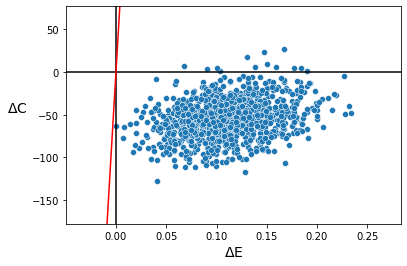

In [9]:
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.ylabel(r'$\Delta$C', rotation=0, fontsize=14, labelpad=14)
plt.xlabel(r'$\Delta$E', fontsize=14)
sns.scatterplot(x=u, y=c)

# Plots some threshold line...
ce_threshold = 20000
x = np.linspace(min(u)-50, max(u)+50, 100)
y = ce_threshold*x
plt.plot(x, y, '-r')

plt.ylim(min(c)-50, max(c)+50) # Add padding to axis limits
plt.xlim(min(u)-0.05, max(u)+0.05)

plt.show()

### 3.1) Counting number of points in each quadrant of the CE plane

In [10]:
NW = 0
NE = 0
SW = 0
SE = 0
count_under_threshold = 0
ce_threshold = 100000
num_iterations = c.shape[0]
for i in range(0, num_iterations):
    if c[i] > 0: # North
        if u[i] > 0: # East
            NE += 1
            y = u[i] * ce_threshold # maximum acceptatble cost at a given value of utility 
            if c[i] < y:
                count_under_threshold += 1
        else: # West
            NW += 1
    else: #South
        if u[i] > 0: # East
            SE += 1
        else: # West
            SW += 1
            
print('North-West:', NW)
print('North-East:', NE, '| Under-threhsold:', count_under_threshold, '| Over-threshold:', NE-count_under_threshold)
print('South-West:', SW)
print('South-East:', SE)
print(NW+NE+SW+SE)

North-West: 0
North-East: 13 | Under-threhsold: 13 | Over-threshold: 0
South-West: 0
South-East: 987
1000


### 3.2) Generate a cost-effectivness acceptability curve

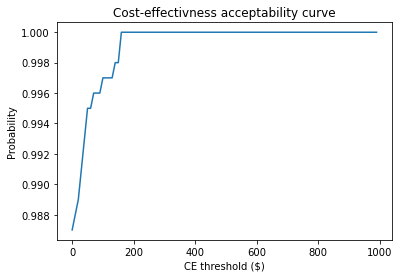

In [11]:
num_iterations = c.shape[0]
ce_threshold_lower = 0
ce_threhsold_upper = 1000
step = 10

points = []
for threshold in range(ce_threshold_lower, ce_threhsold_upper, step):
    count_under_threshold = 0
    for i in range(0, num_iterations):
        y = u[i] * threshold # maximum acceptatble cost at a given value of utility 
        if c[i] < y:
            count_under_threshold += 1
            
    points += [[threshold, count_under_threshold / num_iterations]]

plt.plot([pt[0] for pt in points], [pt[1] for pt in points])
plt.title('Cost-effectivness acceptability curve')
plt.ylabel('Probability')
plt.xlabel('CE threshold ($)')
plt.show()

### 4) Calculating LYG
<b>Note:</b> There are underlying assumptions on the specification of the model for this to work, namely a single state called "death" to exist in both the treatment and base case arms. See function documentation/comments for more details

In [12]:
def calculate_lyg(population_array, model_specification):
    '''
    Function to help calculate life-years-gained (LGY) from the population output. This function
    calculates the required output for one arm. As such, you need to run this function twice; once
    for the base case and once for the treatment arm. 
    
    ie. Calculate as such: LGY_per_iteration = alive_per_iteration_treat - alive_per_iteration_base
    
    Note: Assumes there is a state called "death" and that there is only one state that denotes death
    
    Inputs: population_array = [num_iterations, num_states, num_cycles] shaped numpy array
            state_mapping = a dictionary of state names mapped to a corresponding numeric index
            cycle_length = cycle length of the specified model that created population_array
            discount_rate = a number between 0 and 1 denoting the discount rate
    Outputs: alive_array_per_iteration
    '''
    state_mapping = model_specification.state_mapping
    cycle_length = model_specification.cycle_length
    discount_rate = model_specification.discount_rate
    # Remove death state from array and calculate sum of people alive per cycle, per iteration
    alive_array = np.delete(population_array, state_mapping['death'], axis=1)
    alive_array_per_cycle = np.sum(alive_array, axis=1) * (cycle_length/365)

    # Apply discount rate (as adjusted per cycle)
    # cost * (1 / ((1+discount_rate)**year))
    for i in range(0,alive_array_per_cycle.shape[1]):
        year = math.floor((i*cycle_length)/365)
        alive_array_per_cycle[:,i] = alive_array_per_cycle[:,i] * (1 / ((1+discount_rate)**year))
    
    # Consense into a per-iteration metric of LYG
    alive_array_per_iteration = np.sum(alive_array_per_cycle, axis=1)
   
    return alive_array_per_iteration

lyg_sum_per_iteration_base = calculate_lyg(pop_base, specification_base)
lyg_sum_per_iteration_treat = calculate_lyg(pop_treat, specification_treat)

lyg_compare = lyg_sum_per_iteration_treat - lyg_sum_per_iteration_base

print("Calculated LYG (mean):", np.mean(lyg_compare))

Calculated LYG (mean): 0.11163307554025298


### 5) Calculating EVPI
<b>Note:</b> This is still being developed and hasn't fully been tested yet

In [13]:
# Notes:
# net monetary benefit: threshold * change in effectivness - change in costs > 0 
# net health benefit: change in effectivness - (change in costs / threshold) > 0

# Columns needed:
# A = basecase (NB)
# B = treatment case (NB)
# Optimal choice of an iteration i = max_i(A,B)
# Maximum net benefit = max_i(A,B) (but the value itself)
# If B < A, opportunity loss = A - B, else opportunity loss = 0 
# ----------------------------------------------------------------
# Expectation = Avg(A) | Avg(B) | Avg(max next benefit) | Avg(opportunity loss)

WTP_threshold = 20000

cost_sum_per_iteration_base = outputs_base.iteration_cost_data
utility_sum_per_iteration_base = outputs_base.iteration_util_data
cost_sum_per_iteration_treat = outputs_treat.iteration_cost_data
utility_sum_per_iteration_treat = outputs_treat.iteration_util_data

evpi_df = pd.DataFrame({'A':[],'B':[],'optimal_choice':[],'max_net_benefit':[],
                        'opportunity_loss':[]})

population = 1
num_iterations = utility_sum_per_iteration_base.shape[0] # 1000
for i in range(0, num_iterations):
    
    A = (utility_sum_per_iteration_base[i] * WTP_threshold) - cost_sum_per_iteration_base[i]
    B = (utility_sum_per_iteration_treat[i] * WTP_threshold) - cost_sum_per_iteration_treat[i]
    
    max_net_benefit = max(A,B)
    
    if A >= B:
        opt_choice = 'A'
        opportunity_loss = A - B
    else:
        opt_choice = 'B'
        opportunity_loss = 0
       
    iteration_df = pd.DataFrame({'A':[A],'B':[B],'optimal_choice':[opt_choice],
                                 'max_net_benefit':[max_net_benefit],'opportunity_loss':[opportunity_loss]})
    evpi_df = evpi_df.append(iteration_df)

EVPI = evpi_df.opportunity_loss.mean() * population

print(evpi_df.mean())
print()
print('EVPI:', EVPI)

A                   7368.126877
B                   9649.472840
max_net_benefit     9649.472840
opportunity_loss       0.000000
dtype: float64

EVPI: 0.0


# Extras

### Schematic of model output array:
<img src="../img/outputarray.png" alt="Drawing" style="width: 500px;"/>

### Calculating cost and utility per iteration:
\begin{equation*}
Cost_i = \sum_{j=1}^c\sum_{k=1}^n P_{ijk}C_j \\
Utility_i = \sum_{j=1}^c\sum_{k=1}^n P_{ijk}U_j(\frac{cyclelength}{365}) \\
\end{equation*}
P = [iterations x states x cycles] sized array representing the model 
output<br>
C = mappings of cost per state <br>
U = mappings of utility weight per state <br>
i = iteration <br>
c = number of cycles <br>
n = number of states

### Calculating ICER
#### Calculate mean of costs and utilities across iterations
\begin{equation*}
\text{MeanCost}_{\text{treat}} = \frac{\sum_{i=1}^{\text{iterations}}\text{Cost}_i^{\text{treat}}}{\text{iterations}} \\
\text{MeanCost}_{\text{base}} = \frac{\sum_{i=1}^{\text{iterations}}\text{Cost}_i^{\text{base}}}{\text{iterations}} \\
\text{MeanUtility}_{\text{treat}} = \frac{\sum_{i=1}^{\text{iterations}}\text{Utility}_i^{\text{treat}}}{\text{iterations}} \\
\text{MeanUtility}_{\text{base}} = \frac{\sum_{i=1}^{\text{iterations}}\text{Utility}_i^{\text{base}}}{\text{iterations}} \\
\end{equation*}

#### ICER
\begin{equation*}
\text{ICER} = \frac{\text{MeanCost}_{treat} - \text{MeanCost}_{base}}{\text{MeanUtility}_{treat} - \text{MeanUtility}_{base}}
\end{equation*}